<a href="https://colab.research.google.com/github/githma2000/liver-tumor-segmentation/blob/main/tumor%20segmentation%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

DATASET_PATH = '/content/drive/MyDrive/Preprocessed_3Dircadb'


In [3]:
import os
import random
import shutil

base_dir = '/content/drive/MyDrive/Preprocessed_3Dircadb'
all_patients = sorted([f for f in os.listdir(base_dir) if f.startswith('3Dircadb')])

# Shuffle and split
random.seed(42)
random.shuffle(all_patients)

train_split = int(0.7 * len(all_patients))
val_split = int(0.85 * len(all_patients))

train_patients = all_patients[:train_split]
val_patients = all_patients[train_split:val_split]
test_patients = all_patients[val_split:]

print("Train:", train_patients)
print("Val:", val_patients)
print("Test:", test_patients)


Train: ['3Dircadb1.9', '3Dircadb1.14', '3Dircadb1.4', '3Dircadb1.13', '3Dircadb1.18', '3Dircadb1.3', '3Dircadb1.5', '3Dircadb1.8', '3Dircadb1.15', '3Dircadb1.20', '3Dircadb1.7', '3Dircadb1.19', '3Dircadb1.10', '3Dircadb1.2']
Val: ['3Dircadb1.11', '3Dircadb1.6', '3Dircadb1.16']
Test: ['3Dircadb1.17', '3Dircadb1.1', '3Dircadb1.12']


In [ ]:
pip install albumentations


In [4]:
from tensorflow.keras.utils import Sequence
import numpy as np
import os
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2

class IRCADNPYDataset(Sequence):
    def __init__(self, patient_list, base_path, batch_size=8, input_size=(256, 256), shuffle=True, augment=False):
        self.patient_list = patient_list
        self.base_path = base_path
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.augment = augment  # Whether to apply augmentations
        self.data = self._load_all_files()
        self.on_epoch_end()

        # Define augmentations pipeline
        if self.augment:
            self.transform = A.Compose([
                A.RandomRotate90(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.RandomCrop(width=self.input_size[0], height=self.input_size[1], p=1),
                A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), p=1)
            ])
        else:
            self.transform = A.Compose([
                A.RandomRotate90(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
                A.RandomBrightnessContrast(p=0.3),
                A.ElasticTransform(p=0.2),
                A.GridDistortion(p=0.2),
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
                A.RandomCrop(width=self.input_size[0], height=self.input_size[1], p=1),
                A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0), p=1)
            ])

    def _load_all_files(self):
        data_pairs = []
        for patient in self.patient_list:
            img_dir = os.path.join(self.base_path, patient, 'PATIENT_2_5D')
            mask_dir = os.path.join(self.base_path, patient, 'LABEL_2_5D')

            img_files = sorted(os.listdir(img_dir))
            mask_files = sorted(os.listdir(mask_dir))

            for img_file, mask_file in zip(img_files, mask_files):
                img_path = os.path.join(img_dir, img_file)
                mask_path = os.path.join(mask_dir, mask_file)
                if os.path.isfile(img_path) and os.path.isfile(mask_path):
                    data_pairs.append((img_path, mask_path))
        return data_pairs

    def __len__(self):
        return max(1, len(self.data) // self.batch_size)

    def __getitem__(self, idx):
        batch_pairs = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, masks = [], []

        for img_path, mask_path in batch_pairs:
            img = np.load(img_path)
            img = img.astype(np.float32)

            mask = np.load(mask_path)
            mask = mask.astype(np.float32)

            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=-1)
            elif mask.ndim == 3 and mask.shape[2] > 1:
                mask = mask[..., 0:1]

            min_val = np.min(mask)
            max_val = np.max(mask)
            threshold = min_val + (max_val - min_val) * 0.1
            mask = (mask > threshold).astype(np.float32)

            # Apply augmentations (if enabled)
            if self.transform:
                augmented = self.transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.data)


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout


def ASPP(x, filters):
    shape = x.shape

    y1 = Conv2D(filters, 1, padding="same", use_bias=False, kernel_regularizer=l2(1e-4))(x)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)

    y2 = Conv2D(filters, 3, padding="same", dilation_rate=6, use_bias=False, kernel_regularizer=l2(1e-4))(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filters, 3, padding="same", dilation_rate=12, use_bias=False, kernel_regularizer=l2(1e-4))(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filters, 3, padding="same", dilation_rate=18, use_bias=False, kernel_regularizer=l2(1e-4))(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = tf.keras.layers.GlobalAveragePooling2D()(x)
    y5 = tf.keras.layers.Reshape((1, 1, shape[-1]))(y5)
    y5 = Conv2D(filters, 1, padding="same", use_bias=False, kernel_regularizer=l2(1e-4))(y5)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)
    y5 = UpSampling2D(size=(shape[1], shape[2]), interpolation="bilinear")(y5)

    y = concatenate([y1, y2, y3, y4, y5])
    y = Conv2D(filters, 1, padding="same", use_bias=False, kernel_regularizer=l2(1e-4))(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)
    y = Dropout(0.3)(y)  # Dropout added here

    return y



def DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1):
    """Custom DeepLabV3+ model with ResNet50 backbone"""
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Use features from different levels of the encoder
    image_features = base_model.get_layer("conv4_block6_2_relu").output
    x = ASPP(image_features, 256)

    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    low_level_feat = base_model.get_layer("conv2_block3_2_relu").output
    low_level_feat = Conv2D(48, 1, padding="same", use_bias=False)(low_level_feat)
    low_level_feat = BatchNormalization()(low_level_feat)
    low_level_feat = Activation("relu")(low_level_feat)

    x = concatenate([x, low_level_feat])
    x = Conv2D(256, 3, padding="same", use_bias=False, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)  # Add Dropout

    x = Conv2D(256, 3, padding="same", use_bias=False, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)  # Add Dropout

    x = UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    x = Conv2D(num_classes, 1, padding="same", activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.ndimage import distance_transform_edt

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

def compute_distance_map(seg):
    seg = seg.cpu().numpy()
    dist_map = []
    for s in seg:
        posmask = s.astype(bool)
        negmask = ~posmask
        posdist = distance_transform_edt(negmask)
        negdist = distance_transform_edt(posmask)
        dist = posdist - negdist
        dist_map.append(dist)
    return torch.tensor(dist_map).float().to(seg.device)

class DistanceMapLoss(nn.Module):
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        target = target.float()
        dist_map = compute_distance_map(target)
        return (pred * dist_map).mean()

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, smooth=1.0):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        target = target.float()

        # True Positives
        TP = torch.sum(pred * target)

        # False Positives
        FP = torch.sum(pred * (1 - target))

        # False Negatives
        FN = torch.sum((1 - pred) * target)

        # Tversky Index
        tversky_index = (TP + self.smooth) / (TP + self.alpha * FN + self.beta * FP + self.smooth)

        # Tversky Loss
        return 1 - tversky_index

class CompositeLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3):
        super(CompositeLoss, self).__init__()
        self.dice = DiceLoss()
        self.boundary = DistanceMapLoss()
        self.tversky = TverskyLoss(alpha=alpha, beta=beta)

    def forward(self, pred, target):
        dice_loss = self.dice(pred, target)
        boundary_loss = self.boundary(pred, target)
        tversky_loss = self.tversky(pred, target)

        # Combine the losses
        return dice_loss + boundary_loss + tversky_loss

# Initialize the loss function with Tversky Loss as part of the composite loss
criterion = CompositeLoss(alpha=0.7, beta=0.3)





In [42]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2



def bce_dice_loss(y_true, y_pred):

    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])


    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + 1.0) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1.0)

    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)


    return 1 - dice + bce


def iou_metric(y_true, y_pred, threshold=0.5):

    y_pred = K.cast(K.greater(y_pred, threshold), K.floatx())


    intersection = K.sum(K.cast(y_true * y_pred, K.floatx()))
    union = K.sum(K.cast(y_true + y_pred, K.floatx())) - intersection

    return intersection / (union + K.epsilon())


model = DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=1)


for layer in model.layers:
    layer.trainable = True


model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[iou_metric]
)


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

train_dataset = IRCADNPYDataset(train_patients, base_dir, batch_size=8, augment=True)
val_dataset = IRCADNPYDataset(val_patients, base_dir, batch_size=8, augment=False)
test_dataset = IRCADNPYDataset(test_patients, base_dir, batch_size=8, augment=False)



early_stop = EarlyStopping(
    monitor='val_iou_metric',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)


checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_deeplab_model.keras',
    monitor='val_iou_metric',
    save_best_only=True,
    mode='max',
    verbose=1
)


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-4-d9e41bcb4baa>:38: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - iou_metric: 0.4968 - loss: 0.9162
Epoch 1: val_iou_metric improved from -inf to 0.00000, saving model to /content/drive/MyDrive/best_deeplab_model.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 2244s 9s/step - iou_metric: 0.4971 - loss: 0.9154 - val_iou_metric: 0.0000e+00 - val_loss: 2.9155
Epoch 2/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - iou_metric: 0.6480 - loss: 0.5521
Epoch 2: val_iou_metric did not improve from 0.00000
233/233 ━━━━━━━━━━━━━━━━━━━━ 98s 284ms/step - iou_metric: 0.6481 - loss: 0.5520 - val_iou_metric: 0.0000e+00 - val_loss: 1.6904
Epoch 3/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - iou_metric: 0.6853 - loss: 0.4694
Epoch 3: val_iou_metric did not improve from 0.00000
233/233 ━━━━━━━━━━━━━━━━━━━━ 67s 285ms/step - iou_metric: 0.6854 - loss: 0.4693 - val_iou_metric: 0.0000e+00 - val_loss: 1.9382
Epoch 4/50
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - iou_metric: 0.7260 - loss: 0.3912
Epoch 4: val_iou_metric did not imp

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Initialize your EfficientNet-based model
model_efficientnet = DeeplabV3Plus_EfficientNet(input_shape=(256, 256, 3), num_classes=1)

# Compile the model with your desired optimizer and loss function
model_efficientnet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', iou_metric]  # You can keep your custom IoU metric here
)

# Prepare the datasets for training, validation, and testing
train_dataset = IRCADNPYDataset(train_patients, base_dir, batch_size=8, augment=True)
val_dataset = IRCADNPYDataset(val_patients, base_dir, batch_size=8, augment=False)
test_dataset = IRCADNPYDataset(test_patients, base_dir, batch_size=8, augment=False)

# Define the callbacks
early_stop = EarlyStopping(
    monitor='val_iou_metric',
    patience=5,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_deeplab_model_efficientnet.keras',
    monitor='val_iou_metric',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the EfficientNet model
history_efficientnet = model_efficientnet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)


NameError: name 'DeeplabV3Plus_EfficientNet' is not defined

In [19]:
!sudo apt-get install -y cmake libeigen3-dev
!pip install numpy cython

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
Suggested packages:
  libeigen3-doc libmpfrc++-dev
The following NEW packages will be installed:
  libeigen3-dev
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,056 kB of archives.
After this operation, 9,081 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libeigen3-dev all 3.4.0-2ubuntu2 [1,056 kB]
Fetched 1,056 kB in 1s (1,352 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigu

In [20]:
!git clone https://github.com/lucasb-eyer/pydensecrf.git
%cd pydensecrf
!python setup.py install
%cd ..

Cloning into 'pydensecrf'...
remote: Enumerating objects: 1061, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 1061 (delta 30), reused 28 (delta 28), pack-reused 1022 (from 1)
Receiving objects: 100% (1061/1061), 2.35 MiB | 3.58 MiB/s, done.
Resolving deltas: 100% (473/473), done.
/content/pydensecrf
Compiling pydensecrf/eigen.pyx because it changed.
Compiling pydensecrf/densecrf.pyx because it changed.
[1/2] Cythonizing pydensecrf/densecrf.pyx
/usr/local/lib/python3.11/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/pydensecrf/pydensecrf/densecrf.pxd
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/2] Cythonizing pydensecrf/eigen.pyx
/usr/local/lib/python3.11/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now

In [23]:
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage import color, img_as_ubyte  # Fixed: Use img_as_ubyte instead of img_as_uint
from tensorflow.keras.preprocessing.image import img_to_array

def apply_crf_to_prediction(pred_mask, img):
    """
    Apply CRF (Conditional Random Field) for post-processing.
    Args:
        pred_mask: Predicted segmentation mask (shape: [height, width, num_classes]).
        img: Original RGB image (shape: [height, width, 3]).
    Returns:
        refined_mask: CRF-refined mask (binary).
    """
    # Convert mask to class IDs (binary segmentation)
    pred_mask = np.argmax(pred_mask, axis=-1).astype(np.uint8)

    # Convert image to LAB and scale to 0-255
    img_lab = color.rgb2lab(img)
    img_lab = img_as_ubyte(img_lab)  # Critical: Use ubyte for CRF

    # Initialize CRF (2 classes: foreground/background)
    h, w = img.shape[:2]
    d = dcrf.DenseCRF2D(w, h, 2)

    # Unary potential (negative log probability)
    U = np.stack([-np.log(1.01 - pred_mask), -np.log(pred_mask + 1e-10)], axis=0)
    U = U.reshape((2, -1))
    d.setUnaryEnergy(U.astype(np.float32))  # Must be float32

    # Pairwise potentials (appearance + smoothness)
    d.addPairwiseGaussian(sxy=3, compat=10)
    d.addPairwiseBilateral(sxy=80, srgb=13, rgbim=img_lab, compat=10)

    # Run inference
    Q = d.inference(5)  # 5 iterations
    refined_mask = np.argmax(Q, axis=0).reshape((h, w))

    return refined_mask

# Example usage (assuming you have `model` and `img`):
# pred_mask = model.predict(np.expand_dims(img, axis=0))[0]
# refined_mask = apply_crf_to_prediction(pred_mask, img)

ModuleNotFoundError: No module named 'pydensecrf.densecrf'

In [10]:
from scipy.ndimage import binary_erosion

def get_surface(mask):
    eroded = binary_erosion(mask)
    surface = mask ^ eroded  # XOR: Surface pixels only
    return surface


In [11]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import distance_transform_edt

def dice_coefficient(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    return (2. * intersection) / (pred.sum() + gt.sum())

def voe(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return 1 - (intersection / union)

def rvd(pred, gt):
    return (pred.sum() - gt.sum()) / gt.sum()
def assd(pred, gt):
    pred_surface = get_surface(pred)
    gt_surface = get_surface(gt)
    if np.sum(pred_surface) == 0 or np.sum(gt_surface) == 0:
        return np.nan  # Surface not found
    pred_dist = distance_transform_edt(~pred_surface)
    gt_dist = distance_transform_edt(~gt_surface)
    surface_distances = np.concatenate([
        pred_dist[gt_surface],
        gt_dist[pred_surface]
    ])
    return surface_distances.mean()

def rmsd(pred, gt):
    pred_surface = get_surface(pred)
    gt_surface = get_surface(gt)
    if np.sum(pred_surface) == 0 or np.sum(gt_surface) == 0:
        return np.nan  # Surface not found
    pred_dist = distance_transform_edt(~pred_surface)
    gt_dist = distance_transform_edt(~gt_surface)
    surface_distances = np.concatenate([
        pred_dist[gt_surface],
        gt_dist[pred_surface]
    ])
    return np.sqrt((surface_distances ** 2).mean())


# Example usage
# pred_mask and gt_mask should be binary (0 and 1) masks

# Example dummy masks (replace with your real predictions)
pred_mask = np.random.randint(0, 2, (256, 256))
gt_mask = np.random.randint(0, 2, (256, 256))

dice = dice_coefficient(pred_mask, gt_mask)
voe_score = voe(pred_mask, gt_mask)
rvd_score = rvd(pred_mask, gt_mask)
assd_score = assd(pred_mask, gt_mask)
rmsd_score = rmsd(pred_mask, gt_mask)

print(f"Dice Coefficient: {dice:.4f}")
print(f"VOE: {voe_score:.4f}")
print(f"RVD: {rvd_score:.4f}")
print(f"ASSD: {assd_score:.4f}")
print(f"RMSD: {rmsd_score:.4f}")


Dice Coefficient: 0.4983
VOE: 0.6682
RVD: 0.0062
ASSD: 127.5323
RMSD: 147.3768


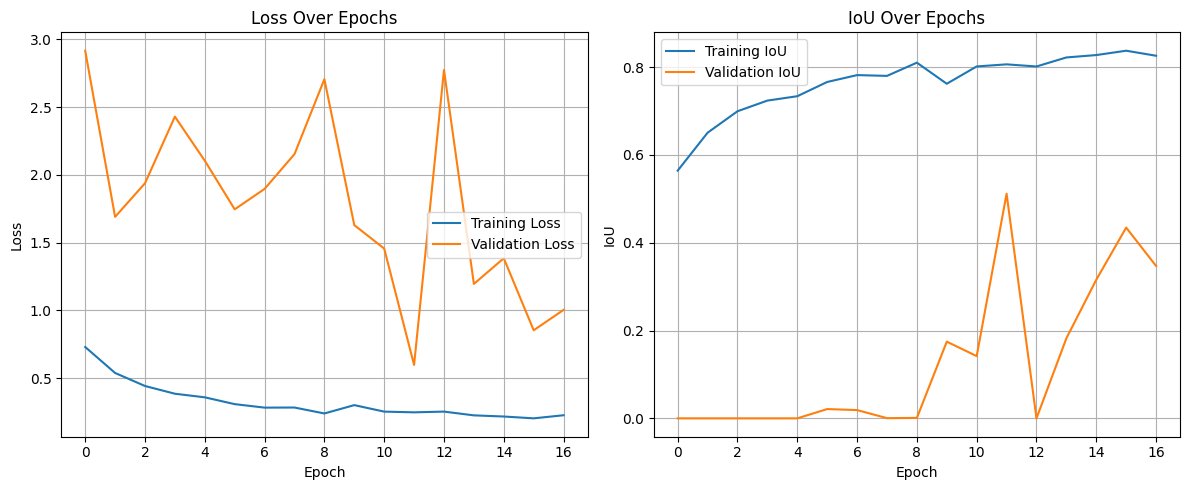

In [12]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot IoU
plt.subplot(1, 2, 2)
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.title('IoU Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
import numpy as np

def compute_confusion_elements(y_true, y_pred, threshold=0.5):
    """
    y_true: ground truth mask (numpy array or tensor), shape: (batch, H, W, 1)
    y_pred: predicted mask (before thresholding), shape: (batch, H, W, 1)
    threshold: probability threshold to binarize predictions
    """
    y_true = y_true.astype(np.bool_)
    y_pred = (y_pred >= threshold).astype(np.bool_)

    TP = np.logical_and(y_pred == 1, y_true == 1).sum()
    FP = np.logical_and(y_pred == 1, y_true == 0).sum()
    TN = np.logical_and(y_pred == 0, y_true == 0).sum()
    FN = np.logical_and(y_pred == 0, y_true == 1).sum()

    return TP, FP, TN, FN


In [14]:
# Predict on validation dataset (just one batch as example)
images, masks = next(iter(val_dataset))  # assuming val_dataset returns numpy arrays
preds = model.predict(images)

# Compute confusion matrix elements
TP, FP, TN, FN = compute_confusion_elements(masks, preds)

print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
TP: 34968, FP: 10448, TN: 451559, FN: 27313


In [15]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
iou = TP / (TP + FP + FN)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1_score:.4f}")
print(f"IoU:       {iou:.4f}")
print(f"Accuracy:  {accuracy:.4f}")


Precision: 0.7699
Recall:    0.5615
F1 Score:  0.6494
IoU:       0.4808
Accuracy:  0.9280


In [ ]:
import numpy as np
import cv2  # OpenCV is great for this task

def post_process_mask(mask, min_area=500):
    """
    Remove small connected components (blobs) from binary mask.

    Parameters:
        mask (np.array): Binary prediction mask (0 and 1)
        min_area (int): Minimum area (in pixels) to keep the component

    Returns:
        cleaned_mask (np.array): Binary mask with small blobs removed
    """
    mask = mask.astype(np.uint8)

    # Find connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

    cleaned_mask = np.zeros_like(mask)

    for i in range(1, num_labels):  # Skip background (label 0)
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            cleaned_mask[labels == i] = 1

    return cleaned_mask
